# Assignment1: Logistic Regression, SGD, and Regularization

First, let's load the data.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Load the data

import re
import random

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data

sst_home = 'drive/My Drive/Colab Notebooks/dl4nlp_labs/data/trees/'  
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

# Note: Unlike with feature based classifiers, evaluation here should be fast, 
# and we don't need to trim down the dev and test sets. 

And extract bag-of-words feature vectors.

In [15]:
import collections
import numpy as np

def feature_function(datasets):
    '''Annotates datasets with feature vectors.'''
    
    # Extract vocabulary
    def tokenize(string):
        return string.split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['text']))
    
    vocabulary = set([word for word in word_counter])
                                
    feature_names = set()
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['features'] = collections.defaultdict(float)
            
            # Extract features (by name) for one example
            word_counter = collections.Counter(tokenize(example['text']))
            for x in word_counter.items():
                if x[0] in vocabulary:
                    example["features"]["word_count_for_" + x[0]] = x[1]
            
            feature_names.update(example['features'].keys())
                            
    # By now, we know what all the features will be, so we can
    # assign indices to them.
    feature_indices = dict(zip(feature_names, range(len(feature_names))))
    indices_to_features = {v: k for k, v in feature_indices.items()}
    dim = len(feature_indices)
                
    # Now we create actual vectors from those indices.
    for dataset in datasets:
        for example in dataset:
            example['vector'] = np.zeros((dim))
            for feature in example['features']:
                example['vector'][feature_indices[feature]] = example['features'][feature]
    return indices_to_features, dim
    
indices_to_features, dim = feature_function([training_set, dev_set, test_set])

And define an evalution function. This is a bit different, since it's designed to let us test an entire big batch of examples at once with the classifier, rather than passing them in one by one. (For larger models or larger training sets, this could run out of memory, but it should be fine for now.)

In [16]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

Now for the fun part! The below should be a working implementation of logistic regression in TensorFlow.

In [17]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.7.0'

In [18]:
class logistic_regression_classifier:
    def __init__(self, dim, lr=1.0,lw=0.0):
        # Define the hyperparameters
        self.learning_rate = lr  # Maybe? Let's tune this
        self.reg_weight = lw  # Regularization weight (lambda)
        self.training_epochs = 50  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = dim  # The number of features
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        
        self.trainable_variables = []
        # Define (most of) the model
        self.W = tf.Variable(tf.zeros([self.dim, 2]))
        self.b = tf.Variable(tf.zeros([2]))
        self.trainable_variables.append(self.W)
        self.trainable_variables.append(self.b)
    def model(self,x):
        logits = tf.matmul(x, self.W) + self.b
        return logits
        
    def train(self, training_data, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.float32(np.vstack([dataset[i]['vector'] for i in indices]))
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels

        print('Training.')

        # Training cycle
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set, 
                                                                    self.batch_size * i, 
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors)

                  # Define the cost function (here, the exp and sum are built in)
                  reg = self.reg_weight * tf.nn.l2_loss(self.W)
                  # Optionally, this should work too:
                  #reg = self.reg_weight * tf.reduce_sum(tf.square(self.W))
                  cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels) + reg)
              
                # This performs the SGD update equation
                gradients = tape.gradient(cost, self.trainable_variables)
                optimizer = tf.keras.optimizers.SGD(self.learning_rate)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                
                # Compute average loss
                avg_cost += cost / total_batch
                
            # Display some statistics about the step
            if (epoch+1) % self.display_epoch_freq == 0:
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost,
                      "Dev acc:", evaluate_classifier(self.classify, dev_set[0:500]), 
                      "Train acc:", evaluate_classifier(self.classify, training_set[0:500]))
    
    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.float32(np.vstack([example['vector'] for example in examples]))
        logits = self.model(vectors)
        return np.argmax(logits, axis=1)

Now let's train it.

In [19]:
classifier = logistic_regression_classifier(dim,1.0,0.0)
classifier.train(training_set, dev_set)

Training.
Epoch: 1 Cost: 0.837631166 Dev acc: 0.56 Train acc: 0.548
Epoch: 2 Cost: 0.792755425 Dev acc: 0.52 Train acc: 0.53
Epoch: 3 Cost: 0.664077759 Dev acc: 0.754 Train acc: 0.758
Epoch: 4 Cost: 0.584600627 Dev acc: 0.642 Train acc: 0.69
Epoch: 5 Cost: 0.549937606 Dev acc: 0.648 Train acc: 0.644
Epoch: 6 Cost: 0.550584435 Dev acc: 0.694 Train acc: 0.738
Epoch: 7 Cost: 0.484218478 Dev acc: 0.712 Train acc: 0.77
Epoch: 8 Cost: 0.510415673 Dev acc: 0.7 Train acc: 0.748
Epoch: 9 Cost: 0.483630359 Dev acc: 0.746 Train acc: 0.786
Epoch: 10 Cost: 0.434588522 Dev acc: 0.78 Train acc: 0.848
Epoch: 11 Cost: 0.426938921 Dev acc: 0.776 Train acc: 0.88
Epoch: 12 Cost: 0.415874362 Dev acc: 0.768 Train acc: 0.826
Epoch: 13 Cost: 0.408803105 Dev acc: 0.782 Train acc: 0.862
Epoch: 14 Cost: 0.391443372 Dev acc: 0.794 Train acc: 0.896
Epoch: 15 Cost: 0.386548638 Dev acc: 0.764 Train acc: 0.828
Epoch: 16 Cost: 0.375883669 Dev acc: 0.786 Train acc: 0.896
Epoch: 17 Cost: 0.371586114 Dev acc: 0.788 Train

And evaluate it.

In [20]:
evaluate_classifier(classifier.classify, test_set)

0.7946183415705657

## Assignments

### Our goals
  1. **Pick an effective learning rate**:
      - You could set up the learning rate value by passing it as argument (e.g. in `__init__ (self, dim, lr=1.0, ...)` )
      - Try small and larger values to see the behavior of the model.
  
  2. **Implement L2 regularization:**
      - Hint: Add regularization term to overal cost (`self.cost`)
      - Tensorflow already built in method for this. Check the API to find out. 
      - (Optionaly) Code it without using the built in tool for it

  3. **Pick an effective L2 weight:**
      - You could set up the learning rate and l2 weight values by passing it as argument (e.g. in `__init__ (self, dim, lw=1.0, ...)` )
      - Try small and larger values to see the behavior of the model.
  
  4. **Look at some learning curves:**
      - This code might be helpful: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


Solution: I changed the code above to obtain the goals of setting an effective learning rate, implementing regularization and setting lambda weight.

In [21]:
lw = 0.0
lrs = [0.05, 0.1, 0.25, 0.5, 0.85, 1.0, 2.0, 3.0]
train_acc = []
dev_acc = []
max_dev_acc = 0.0
for lr in lrs:
    print("[Checking] Learning rate: {}".format(lr))
    classifier = logistic_regression_classifier(dim,lr=lr)
    classifier.train(training_set, dev_set)
    train = evaluate_classifier(classifier.classify, training_set)
    dev = evaluate_classifier(classifier.classify, dev_set)
    train_acc.append(train)
    dev_acc.append(dev)
    
    if max_dev_acc < dev:
        max_dev_acc= dev
        max_dev_lr=lr
    
    print("[Result] lr: {}, Training acc: {}, Dev acc: {}\n".format(lr, train, dev))
print("[Best result] lr: {}, Dev acc: {}".format(max_dev_lr,max_dev_acc))


[Checking] Learning rate: 0.05
Training.
Epoch: 1 Cost: 0.686360657 Dev acc: 0.618 Train acc: 0.61
Epoch: 2 Cost: 0.675724506 Dev acc: 0.654 Train acc: 0.582
Epoch: 3 Cost: 0.667866945 Dev acc: 0.652 Train acc: 0.626
Epoch: 4 Cost: 0.661190152 Dev acc: 0.662 Train acc: 0.612
Epoch: 5 Cost: 0.65570271 Dev acc: 0.668 Train acc: 0.588
Epoch: 6 Cost: 0.650665402 Dev acc: 0.67 Train acc: 0.672
Epoch: 7 Cost: 0.645822823 Dev acc: 0.676 Train acc: 0.67
Epoch: 8 Cost: 0.64155513 Dev acc: 0.682 Train acc: 0.688
Epoch: 9 Cost: 0.6373083 Dev acc: 0.684 Train acc: 0.698
Epoch: 10 Cost: 0.633650541 Dev acc: 0.688 Train acc: 0.656
Epoch: 11 Cost: 0.629947126 Dev acc: 0.692 Train acc: 0.674
Epoch: 12 Cost: 0.626231313 Dev acc: 0.706 Train acc: 0.7
Epoch: 13 Cost: 0.622971 Dev acc: 0.7 Train acc: 0.668
Epoch: 14 Cost: 0.619807959 Dev acc: 0.708 Train acc: 0.684
Epoch: 15 Cost: 0.616630793 Dev acc: 0.716 Train acc: 0.728
Epoch: 16 Cost: 0.61360693 Dev acc: 0.718 Train acc: 0.712
Epoch: 17 Cost: 0.61084

In [22]:
## Original code from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(par_values, train_scores, dev_scores, title ="Train-Dev Learning Curve", ylim=None, xlab="Learning rate", ylab="Accuracy"):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    par_values : list of checked values of the current parameter.
    
    train_scores : list of scores obtained in training set (same length as par_values).
    
    test_scores : list of scores obtained in dev set (same length as par_values)
    
    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.grid()

    plt.plot(par_values, train_scores, 'o-', color="r",
             label="Training score")
    plt.plot(par_values, dev_scores, 'o-', color="g",
             label="Dev score")

    plt.legend(loc="best")
    return plt


[0.05, 0.1, 0.25, 0.5, 0.85, 1.0, 2.0, 3.0]
[0.7671965317919075, 0.8154624277456647, 0.8747109826589595, 0.9190751445086706, 0.9452312138728324, 0.9530346820809249, 0.9794797687861272, 0.9874277456647399]
[0.7339449541284404, 0.7373853211009175, 0.7672018348623854, 0.7660550458715596, 0.7672018348623854, 0.7729357798165137, 0.7626146788990825, 0.7591743119266054]


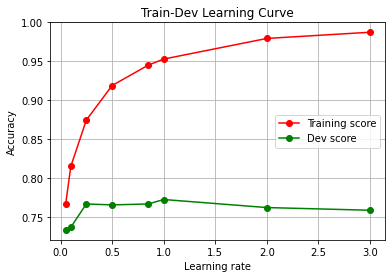

In [23]:
lc = plot_learning_curve(lrs, train_acc, dev_acc)
print(lrs)
print(train_acc)
print(dev_acc)
lc.show()

Fixed learning rate, check different regularization weigths:

In [24]:
lr = max_dev_lr
lws = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
train_acc2 = []
dev_acc2 = []
for lw in lws:
    print("[Checking] Regularization weight: {}".format(lw))
    classifier = logistic_regression_classifier(dim,lr=lr,lw=lw)
    classifier.train(training_set, dev_set)
    train = evaluate_classifier(classifier.classify, training_set)
    dev = evaluate_classifier(classifier.classify, dev_set)
    train_acc2.append(train)
    dev_acc2.append(dev)
    print("[Result] lr: {}, lw: {} Training acc: {}, Dev acc: {}\n".format(lr, lw, train, dev))

[Checking] Regularization weight: 0.0
Training.
Epoch: 1 Cost: 0.891604781 Dev acc: 0.51 Train acc: 0.544
Epoch: 2 Cost: 0.803297 Dev acc: 0.56 Train acc: 0.588
Epoch: 3 Cost: 0.686212122 Dev acc: 0.766 Train acc: 0.772
Epoch: 4 Cost: 0.591993272 Dev acc: 0.702 Train acc: 0.75
Epoch: 5 Cost: 0.551747739 Dev acc: 0.764 Train acc: 0.776
Epoch: 6 Cost: 0.521328747 Dev acc: 0.75 Train acc: 0.764
Epoch: 7 Cost: 0.485789567 Dev acc: 0.764 Train acc: 0.842
Epoch: 8 Cost: 0.469931602 Dev acc: 0.78 Train acc: 0.82
Epoch: 9 Cost: 0.464503706 Dev acc: 0.774 Train acc: 0.822
Epoch: 10 Cost: 0.435694844 Dev acc: 0.774 Train acc: 0.84
Epoch: 11 Cost: 0.42661047 Dev acc: 0.782 Train acc: 0.872
Epoch: 12 Cost: 0.410450697 Dev acc: 0.782 Train acc: 0.874
Epoch: 13 Cost: 0.410350591 Dev acc: 0.782 Train acc: 0.872
Epoch: 14 Cost: 0.395451933 Dev acc: 0.744 Train acc: 0.814
Epoch: 15 Cost: 0.384186596 Dev acc: 0.766 Train acc: 0.854
Epoch: 16 Cost: 0.378093183 Dev acc: 0.79 Train acc: 0.894
Epoch: 17 Cos

[0.0, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
[0.9546242774566474, 0.9534682080924856, 0.9539017341040462, 0.9527456647398844, 0.9173410404624277, 0.5092485549132948, 0.6203757225433526, 0.4784682080924855, 0.47832369942196534, 0.47832369942196534]
[0.7660550458715596, 0.7717889908256881, 0.7694954128440367, 0.7672018348623854, 0.7637614678899083, 0.5080275229357798, 0.6204128440366973, 0.4908256880733945, 0.4908256880733945, 0.4908256880733945]


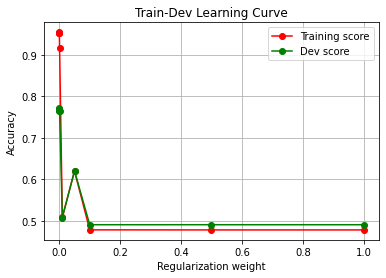

In [25]:
print(lws)
print(train_acc2)
print(dev_acc2)
lc2 = plot_learning_curve(lws, train_acc2, dev_acc2, xlab="Regularization weight")
lc2.show()